In [1]:
import sys
sys.path.append('../')

In [180]:
import pandas as pd
import datetime as dt
import plotly.graph_objects as go
from technicals.indicators import RSI
from technicals.patterns import apply_patterns
from plotting import CandlePlot

In [136]:
df_raw = pd.read_pickle('../data/USD_JPY_H1.pkl')

In [137]:
df_raw.shape

(49758, 14)

In [138]:
df_an = apply_patterns(df_raw)

In [139]:
df_an = df_an.copy()
df_an.reset_index(inplace=True, drop=True)

In [140]:
df_an.shape

(49758, 40)

In [141]:
df_an_rsi = RSI(df_an)

In [142]:
df_an_rsi.shape

(49758, 41)

In [143]:
df_an_rsi.head()

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,...,HANGING_MAN,SHOOTING_STAR,SPINNING_TOP,MARUBOZU,ENGULFING,TWEEZER_TOP,TWEEZER_BOTTOM,MORNING_STAR,EVENING_STAR,RSI_14
0,2016-01-03 22:00:00+00:00,1556,120.195,120.330,120.194,120.294,120.145,120.309,120.144,120.274,...,False,False,False,False,False,False,False,False,False,NaN
1,2016-01-03 23:00:00+00:00,1308,120.288,120.392,120.232,120.320,120.270,120.380,120.222,120.311,...,False,False,False,False,False,False,False,False,False,NaN
2,2016-01-04 00:00:00+00:00,908,120.316,120.392,120.271,120.374,120.307,120.384,120.261,120.365,...,False,False,False,False,False,False,False,False,False,NaN
3,2016-01-04 01:00:00+00:00,1969,120.372,120.464,120.010,120.030,120.364,120.456,120.001,120.022,...,False,False,False,False,True,False,False,False,False,NaN
4,2016-01-04 02:00:00+00:00,4086,120.030,120.046,119.650,119.820,120.022,120.037,119.641,119.811,...,False,False,False,False,False,False,False,False,False,NaN


In [144]:
# Let's make 200 moving average
df_an_rsi['EMA_200'] = df_an_rsi.mid_c.ewm(span=200, min_periods=200).mean()

In [145]:
df_an_rsi.columns

Index(['time', 'volume', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'bid_o', 'bid_h',
       'bid_l', 'bid_c', 'ask_o', 'ask_h', 'ask_l', 'ask_c', 'body_lower',
       'body_upper', 'body_bottom_perc', 'body_top_perc', 'body_perc',
       'direction', 'body_size', 'low_change', 'high_change',
       'body_size_change', 'mid_point', 'mid_point_prev_2', 'body_size_prev',
       'direction_prev', 'direction_prev_2', 'body_perc_prev',
       'body_perc_prev_2', 'HANGING_MAN', 'SHOOTING_STAR', 'SPINNING_TOP',
       'MARUBOZU', 'ENGULFING', 'TWEEZER_TOP', 'TWEEZER_BOTTOM',
       'MORNING_STAR', 'EVENING_STAR', 'RSI_14', 'EMA_200'],
      dtype='object')

In [146]:
our_cols = ['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c', 'bid_c', 'ask_c', 'direction', 'ENGULFING', 'RSI_14', 'EMA_200']

In [147]:
df_slim = df_an_rsi[our_cols].copy()
df_slim.dropna(inplace=True)
df_slim.reset_index(inplace=True, drop=True)
df_slim.head()

,time,mid_o,mid_h,mid_l,mid_c,bid_c,ask_c,direction,ENGULFING,RSI_14,EMA_200
0,2016-01-14 05:00:00+00:00,117.404,117.703,117.398,117.636,117.627,117.646,1,True,44.768347,117.998586
1,2016-01-14 06:00:00+00:00,117.641,117.922,117.611,117.910,117.903,117.918,1,False,54.868118,117.997568
2,2016-01-14 07:00:00+00:00,117.910,118.178,117.842,118.102,118.095,118.109,1,False,60.340829,117.998766
3,2016-01-14 08:00:00+00:00,118.102,118.102,117.688,117.718,117.711,117.726,-1,True,47.844881,117.995550
4,2016-01-14 09:00:00+00:00,117.716,118.008,117.601,117.894,117.887,117.902,1,False,52.681633,117.994388


#### Let's check for the entry either BUY(RSI > 50, Candle = Bullish Engulfing, EMA below candle low) or SELL (RSI <50, Candle = Bearish Engulfing, EMA abovec andle high)

In [148]:
BUY = 1
SELL = -1
NONE = 0
RSI_LIMIT = 50.0
TAKE_PROFIT = 1.5
STOP_LOSS = -1

In [149]:
def check_trade(row):
    if row.ENGULFING == True:
        if (row.direction == BUY) and (row.RSI_14 < RSI_LIMIT) and (row.mid_l > row.EMA_200):
            return BUY
        elif (row.direction == SELL) and (row.RSI_14 > RSI_LIMIT) and (row.mid_h < row.EMA_200):
            return SELL
    return NONE
            

In [150]:
df_slim['trade'] = df_slim.apply(check_trade, axis=1)

In [151]:
df_slim.head()

,time,mid_o,mid_h,mid_l,mid_c,bid_c,ask_c,direction,ENGULFING,RSI_14,EMA_200,trade
0,2016-01-14 05:00:00+00:00,117.404,117.703,117.398,117.636,117.627,117.646,1,True,44.768347,117.998586,0
1,2016-01-14 06:00:00+00:00,117.641,117.922,117.611,117.910,117.903,117.918,1,False,54.868118,117.997568,0
2,2016-01-14 07:00:00+00:00,117.910,118.178,117.842,118.102,118.095,118.109,1,False,60.340829,117.998766,0
3,2016-01-14 08:00:00+00:00,118.102,118.102,117.688,117.718,117.711,117.726,-1,True,47.844881,117.995550,0
4,2016-01-14 09:00:00+00:00,117.716,118.008,117.601,117.894,117.887,117.902,1,False,52.681633,117.994388,0


In [152]:
# df_slim[(df_slim['trade'] == 1) | (df_slim['trade'] == -1)]
df_slim['trade'].value_counts()

trade
 0    48613
 1      504
-1      442
Name: count, dtype: int64

In [153]:
def apply_take_profit(row):
    if row.trade != NONE:
        return (row.mid_c - row.mid_o) * 1.5 + row.mid_c
    else:
        return 0.0

def apply_stop_loss(row):
    if row.trade != NONE:
        return row.mid_o
    else:
        return 0.0

In [154]:
df_slim['TP'] = df_slim.apply(apply_take_profit, axis=1)
df_slim['SL'] = df_slim.apply(apply_stop_loss, axis=1)

In [155]:
df_slim.head()

,time,mid_o,mid_h,mid_l,mid_c,bid_c,ask_c,direction,ENGULFING,RSI_14,EMA_200,trade,TP,SL
0,2016-01-14 05:00:00+00:00,117.404,117.703,117.398,117.636,117.627,117.646,1,True,44.768347,117.998586,0,0.0,0.0
1,2016-01-14 06:00:00+00:00,117.641,117.922,117.611,117.910,117.903,117.918,1,False,54.868118,117.997568,0,0.0,0.0
2,2016-01-14 07:00:00+00:00,117.910,118.178,117.842,118.102,118.095,118.109,1,False,60.340829,117.998766,0,0.0,0.0
3,2016-01-14 08:00:00+00:00,118.102,118.102,117.688,117.718,117.711,117.726,-1,True,47.844881,117.995550,0,0.0,0.0
4,2016-01-14 09:00:00+00:00,117.716,118.008,117.601,117.894,117.887,117.902,1,False,52.681633,117.994388,0,0.0,0.0


In [156]:
df_slim[df_slim.trade != NONE].head(10)

,time,mid_o,mid_h,mid_l,mid_c,bid_c,ask_c,direction,ENGULFING,RSI_14,EMA_200,trade,TP,SL
64,2016-01-18 21:00:00+00:00,117.349,117.358,117.274,117.344,117.318,117.371,-1,True,52.118515,117.714531,-1,117.3365,117.349
174,2016-01-25 11:00:00+00:00,118.404,118.460,118.354,118.420,118.412,118.427,1,True,49.512688,117.739480,1,118.4440,118.404
185,2016-01-25 22:00:00+00:00,118.306,118.354,118.296,118.344,118.333,118.356,1,True,45.886652,117.815198,1,118.4010,118.306
189,2016-01-26 02:00:00+00:00,118.104,118.271,118.052,118.238,118.230,118.247,1,True,44.158513,117.829860,1,118.4390,118.104
215,2016-01-27 04:00:00+00:00,118.104,118.358,118.076,118.320,118.311,118.328,1,True,49.621233,117.939047,1,118.6440,118.104
313,2016-02-02 06:00:00+00:00,120.434,120.725,120.420,120.652,120.645,120.660,1,True,42.388930,119.355550,1,120.9790,120.434
315,2016-02-02 08:00:00+00:00,120.630,120.762,120.586,120.658,120.651,120.666,1,True,42.880372,119.381233,1,120.7000,120.630
337,2016-02-03 06:00:00+00:00,119.608,119.668,119.527,119.656,119.648,119.664,1,True,30.012008,119.514614,1,119.7280,119.608
410,2016-02-08 07:00:00+00:00,117.486,117.489,117.275,117.318,117.312,117.325,-1,True,58.439164,118.398809,-1,117.0660,117.486
520,2016-02-12 21:00:00+00:00,113.299,113.314,113.191,113.225,113.175,113.275,-1,True,58.026417,115.186193,-1,113.1140,113.299


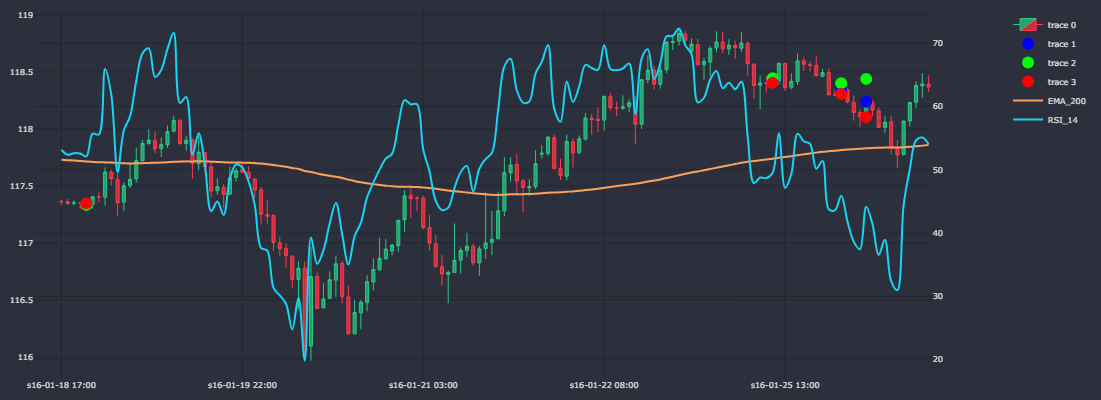

In [163]:
df_plot = df_slim.iloc[60:200].copy()
cp = CandlePlot(df_plot)

marker = ['mid_c', 'TP', 'SL']
marker_color = ['#0000FF', '#00FF00', '#FF0000']

trades = cp.df_plot[cp.df_plot.trade != NONE]

for i in range(3):
    cp.fig.add_trace(go.Scatter(
        x = trades.sTime,
        y = trades[marker[i]],
        mode='markers',
        marker = dict(color=marker_color[i], size=12)
    ))

cp.show_plot(line_traces=['EMA_200'], sec_traces=['RSI_14'])

## Let's do the simulation for this stratergy

In [158]:
class Trade:
    def __init__(self, row):
        self.running = True # The trade is running initially when it opens
        self.start_index = row.name
        self.start_price = row.mid_c
        self.trigger_price = row.mid_c
        self.SIGNAL = row.trade
        self.TP = row.TP
        self.SL = row.SL
        self.result = 0.0
        self.end_time = row.time
        self.start_time = row.time
        self.duration = 0

    def close_trade(self, row, result, trigger_price):
        self.running = False
        self.result = result
        self.end_time = row.time
        self.trigger_price = trigger_price

    def update(self, row):
        self.duration += 1
        if self.SIGNAL == BUY:
            if row.mid_h >= self.TP:
                self.close_trade(row, TAKE_PROFIT, row.mid_h)
            elif row.mid_l <= self.SL:
                self.close_trade(row, STOP_LOSS, row.mid_l)

        elif self.SIGNAL == SELL:
            if row.mid_l <= self.TP:
                self.close_trade(row, TAKE_PROFIT, row.mid_l)
            elif row.mid_h >= self.SL:
                self.close_trade(row, STOP_LOSS, row.mid_h)

In [159]:
open_trades = []
close_trades = []

for index, row in df_slim.iterrows():
    for ot in open_trades:
        ot.update(row)
        if ot.running == False:
            close_trades.append(ot)
    open_trades = [x for x in open_trades if x.running == True]

    if row.trade != NONE:
        open_trades.append(Trade(row))

In [160]:
print("Total trades in dataframe: ", len(df_slim[df_slim['trade'] != NONE]))
print("Total Opening Trades Remaining: ", len(open_trades))
print("Close Trades: ", len(close_trades))

Total trades in dataframe:  946
Total Opening Trades Remaining:  0
Close Trades:  946


As you can see all trades are closed

In [161]:
df_results = pd.DataFrame([vars(x) for x in close_trades])
df_results.head()

,running,start_index,start_price,trigger_price,SIGNAL,TP,SL,result,end_time,start_time,duration
0,False,64,117.344,117.300,-1,117.3365,117.349,1.5,2016-01-18 22:00:00+00:00,2016-01-18 21:00:00+00:00,1
1,False,174,118.420,118.580,1,118.4440,118.404,1.5,2016-01-25 12:00:00+00:00,2016-01-25 11:00:00+00:00,1
2,False,185,118.344,118.225,1,118.4010,118.306,-1.0,2016-01-25 23:00:00+00:00,2016-01-25 22:00:00+00:00,1
3,False,189,118.238,118.010,1,118.4390,118.104,-1.0,2016-01-26 04:00:00+00:00,2016-01-26 02:00:00+00:00,2
4,False,215,118.320,118.075,1,118.6440,118.104,-1.0,2016-01-27 08:00:00+00:00,2016-01-27 04:00:00+00:00,4


In [162]:
print(f"Total Orders are: {(df_results.shape[0])} and the pip gain is: {df_results.result.sum()}") 

Total Orders are: 946 and the pip gain is: 204.0


As you can see it isn't a big pip gain at all. We are placing 306 orders and get a profit of only 76 pips and that is also in optimistic way. Meaning currenly if the next candle hit the TP and SL, we are considering TP to be hit first

In [164]:
# Let's look at the 5 minite dataframe
df_5_minute = pd.read_pickle('../data/USD_JPY_M5.pkl')

In [165]:
df_5_minute.shape

(595605, 14)

In [166]:
df_5_minute.time.min()

Timestamp('2016-01-03 22:00:00+0000', tz='tzutc()')

In [167]:
df_raw.time.min()

Timestamp('2016-01-03 22:00:00+0000', tz='tzutc()')

In [168]:
df_raw.time.max()

Timestamp('2023-12-29 21:00:00+0000', tz='tzutc()')

In [169]:
df_5_minute.time.max()

Timestamp('2023-12-29 21:55:00+0000', tz='tzutc()')

In [177]:
# Let's inspect the order that has the TP and SL hit bot at the next candle 25 Jan 2016 11:00am
start_time = '2016-01-25 11:00:00+00:00'
end_time = '2016-01-25 13:00:00+00:00'

In [178]:
df_raw[(df_raw.time >= start_time) & (df_raw.time <= end_time)]

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c
373,2016-01-25 11:00:00+00:00,1140,118.404,118.460,118.354,118.420,118.395,118.452,118.343,118.412,118.413,118.469,118.362,118.427
374,2016-01-25 12:00:00+00:00,1181,118.421,118.580,118.388,118.576,118.413,118.572,118.381,118.569,118.429,118.587,118.395,118.584
375,2016-01-25 13:00:00+00:00,1800,118.574,118.584,118.331,118.362,118.566,118.577,118.323,118.353,118.581,118.592,118.338,118.370


In [179]:
df_5_minute[(df_5_minute.time >= start_time) & (df_5_minute.time <= end_time)]

,time,volume,mid_o,mid_h,mid_l,mid_c,bid_o,bid_h,bid_l,bid_c,ask_o,ask_h,ask_l,ask_c
4476,2016-01-25 11:00:00+00:00,104,118.404,118.442,118.400,118.420,118.395,118.434,118.392,118.413,118.413,118.451,118.407,118.428
4477,2016-01-25 11:05:00+00:00,121,118.424,118.424,118.384,118.400,118.415,118.417,118.377,118.392,118.433,118.433,118.392,118.407
4478,2016-01-25 11:10:00+00:00,84,118.396,118.414,118.376,118.408,118.388,118.407,118.368,118.401,118.403,118.421,118.383,118.416
4479,2016-01-25 11:15:00+00:00,81,118.406,118.414,118.394,118.414,118.398,118.407,118.385,118.406,118.413,118.423,118.401,118.422
4480,2016-01-25 11:20:00+00:00,72,118.413,118.434,118.406,118.423,118.406,118.426,118.397,118.415,118.420,118.443,118.414,118.431
4481,2016-01-25 11:25:00+00:00,73,118.425,118.452,118.422,118.436,118.417,118.444,118.414,118.427,118.433,118.459,118.430,118.444
4482,2016-01-25 11:30:00+00:00,101,118.436,118.460,118.436,118.445,118.429,118.452,118.429,118.438,118.443,118.469,118.443,118.452
4483,2016-01-25 11:35:00+00:00,102,118.442,118.453,118.416,118.416,118.434,118.445,118.408,118.408,118.449,118.461,118.423,118.423
4484,2016-01-25 11:40:00+00:00,84,118.420,118.428,118.388,118.402,118.412,118.421,118.378,118.394,118.427,118.436,118.398,118.410
4485,2016-01-25 11:45:00+00:00,131,118.406,118.408,118.354,118.376,118.398,118.401,118.346,118.368,118.414,118.417,118.362,118.385


As you can see from the above that the SL is hit first instead of TP which we take TP in H1 simulation

## Let's hit the TP and SL in the lower time frame (M5) candles

In [181]:
df_5_slim = df_5_minute[['time', 'mid_h', 'mid_l']].copy()
df_5_slim.head()

,time,mid_h,mid_l
0,2016-01-03 22:00:00+00:00,120.225,120.194
1,2016-01-03 22:05:00+00:00,120.235,120.208
2,2016-01-03 22:10:00+00:00,120.238,120.209
3,2016-01-03 22:15:00+00:00,120.253,120.214
4,2016-01-03 22:20:00+00:00,120.258,120.233


In [192]:
df_signals = df_slim[df_slim.trade != NONE]
df_signals['m5_start'] = [x +  dt.timedelta(hours=1) for x in df_signals.time]
df_signals['start_index_h1'] = df_signals.index
df_signals.drop(['time', 'mid_o', 'mid_l', 'mid_h', 'ask_c', 'bid_c', 'ENGULFING', 'EMA_200', 'RSI_14'], inplace=True, axis=1)
df_signals.rename(columns={
    'm5_start': 'time',
    'mid_c': 'start_price'
}, inplace=True)
df_signals.head()

C:\Users\PMLS\AppData\Local\Temp\ipykernel_14012\2731587832.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PMLS\AppData\Local\Temp\ipykernel_14012\2731587832.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PMLS\AppData\Local\Temp\ipykernel_14012\2731587832.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

,start_price,direction,trade,TP,SL,time,start_index_h1
64,117.344,-1,-1,117.3365,117.349,2016-01-18 22:00:00+00:00,64
174,118.420,1,1,118.4440,118.404,2016-01-25 12:00:00+00:00,174
185,118.344,1,1,118.4010,118.306,2016-01-25 23:00:00+00:00,185
189,118.238,1,1,118.4390,118.104,2016-01-26 03:00:00+00:00,189
215,118.320,1,1,118.6440,118.104,2016-01-27 05:00:00+00:00,215


In [199]:
# Let's finally merged the datasets
merges = pd.merge(left=df_5_slim, right=df_signals, on='time', how='left')
merges.fillna(0, inplace=True)
merges.trade = merges.trade.astype(int)
merges.start_index_h1 = merges.start_index_h1.astype(int)

In [201]:
merges[merges.trade != NONE].head()

,time,mid_h,mid_l,start_price,direction,trade,TP,SL,start_index_h1
3168,2016-01-18 22:00:00+00:00,117.344,117.328,117.344,-1.0,-1,117.3365,117.349,64
4488,2016-01-25 12:00:00+00:00,118.450,118.388,118.420,1.0,1,118.4440,118.404,174
4620,2016-01-25 23:00:00+00:00,118.360,118.322,118.344,1.0,1,118.4010,118.306,185
4668,2016-01-26 03:00:00+00:00,118.244,118.202,118.238,1.0,1,118.4390,118.104,189
4980,2016-01-27 05:00:00+00:00,118.319,118.256,118.320,1.0,1,118.6440,118.104,215


In [208]:
# Let's define the class for M5
class TradeM5:
    def __init__(self, row):
        self.running = True # The trade is running initially when it opens
        self.start_index_m5 = row.name
        self.start_index_h1 = row.start_index_h1
        self.start_price = row.start_price
        self.trigger_price = row.start_price
        self.SIGNAL = row.trade
        self.TP = row.TP
        self.SL = row.SL
        self.result = 0.0
        self.end_time = row.time
        self.start_time = row.time
        self.duration = 1

    def close_trade(self, row, result, trigger_price):
        self.running = False
        self.result = result
        self.end_time = row.time
        self.trigger_price = trigger_price

    def update(self, row):
        self.duration += 1
        if self.SIGNAL == BUY:
            if row.mid_h >= self.TP:
                self.close_trade(row, TAKE_PROFIT, row.mid_h)
            elif row.mid_l <= self.SL:
                self.close_trade(row, STOP_LOSS, row.mid_l)

        elif self.SIGNAL == SELL:
            if row.mid_l <= self.TP:
                self.close_trade(row, TAKE_PROFIT, row.mid_l)
            elif row.mid_h >= self.SL:
                self.close_trade(row, STOP_LOSS, row.mid_h)

In [204]:
open_trades_m5 = []
close_trades_m5 = []

for index, row in merges.iterrows():
    if row.trade != NONE:
        open_trades_m5.append(TradeM5(row))
    
    for ot in open_trades_m5:
        ot.update(row)
        if ot.running == False:
            close_trades_m5.append(ot)
    open_trades_m5 = [x for x in open_trades_m5 if x.running == True]


In [205]:
print("Total trades in dataframe: ", len(merges[merges['trade'] != NONE]))
print("Total Opening Trades Remaining: ", len(open_trades_m5))
print("Close Trades: ", len(close_trades_m5))

Total trades in dataframe:  932
Total Opening Trades Remaining:  0
Close Trades:  932


In [206]:
df_res_m5 = pd.DataFrame.from_dict([vars(x) for x in close_trades_m5])

In [207]:
df_res_m5.head()

,running,start_index_m5,start_index_h1,start_price,trigger_price,SIGNAL,TP,SL,result,end_time,start_time,duration
0,False,3168,64,117.344,117.328,-1,117.3365,117.349,1.5,2016-01-18 22:00:00+00:00,2016-01-18 22:00:00+00:00,1
1,False,4488,174,118.420,118.450,1,118.4440,118.404,1.5,2016-01-25 12:00:00+00:00,2016-01-25 12:00:00+00:00,1
2,False,4620,185,118.344,118.260,1,118.4010,118.306,-1.0,2016-01-25 23:45:00+00:00,2016-01-25 23:00:00+00:00,10
3,False,4668,189,118.238,118.076,1,118.4390,118.104,-1.0,2016-01-26 04:10:00+00:00,2016-01-26 03:00:00+00:00,15
4,False,4980,215,118.320,118.092,1,118.6440,118.104,-1.0,2016-01-27 08:10:00+00:00,2016-01-27 05:00:00+00:00,39


In [210]:
print(f"Total Orders are: {(df_results.shape[0])} and the pip gain is: {df_res_m5.result.sum()}") 

Total Orders are: 946 and the pip gain is: 48.0


As you can see we have gone from 204 to 48. This can may be more reduced if we go down to 1 minute dataframe. That's also not include the spread